In [1]:
import pandas as pd
import numpy as np
import joblib
import math
from keras.models import load_model

import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 데스크탑
df = pd.read_csv("C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\fog_train.csv", index_col=0)

# 노트북
# df = pd.read_csv("C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\fog_train.csv", index_col=0)

In [3]:
df.columns = [col.split('.')[-1] if '.' in col else col for col in df.columns]

## year열 클래스(I,J,K) 수치화

In [4]:
# year열 I,J,K 순으로 0,1,2로 맵핑
df['year'] = df['year'].map({'I': 0, 'J': 1, 'K': 2})
df['year'].value_counts()

0    1054060
2    1051200
1    1051199
Name: year, dtype: int64

## 20개 지점을 5개의 지역으로 수치화 및 2번 지역 추출

In [5]:
# 첫 글자를 추출하여 새로운 열 생성
df['first_letter'] = df['stn_id'].str[0]

# 알파벳 순서에 따라 번호를 부여
alphabet_order = {char: idx for idx, char in enumerate(sorted(df['first_letter'].unique()))}
df['stn_id'] = df['first_letter'].map(alphabet_order)
df.drop(columns=['first_letter'], inplace=True)

df['stn_id'].value_counts()

0    1262584
1     631292
3     473469
4     473468
2     315646
Name: stn_id, dtype: int64

In [6]:
# m(4, E)번 지역만 추출
m = 4 
df2 = df[df['stn_id'].isin([m])]
df2['stn_id'].value_counts()

4    473468
Name: stn_id, dtype: int64

## x(독립변수) 결측값 대체
#### year, month, day, time, minute, re, vis1, class 제외
> **선형보간법** 사용

In [7]:
numeric_cols = ['ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts']

# -99.9 값을 NaN으로 변환
df2[numeric_cols] = df2[numeric_cols].replace(-99.9, np.nan)

# 선형보간법을 이용하여 NaN값 처리
df2[numeric_cols] = df2[numeric_cols].interpolate(method='linear')

c:\Users\Hong_PC\anaconda3\envs\mjh\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [8]:
# NaN 값 남았는지 확인
ws10_deg = df2[df2['ws10_deg'] == -99.9]
ws10_ms = df2[df2['ws10_ms'] == -99.9]
ta = df2[df2['ta'] == -99.9]
hm = df2[df2['hm'] == -99.9]
sun10 = df2[df2['sun10'] == -99.9]
ts = df2[df2['ts'] == -99.9]

print(ws10_deg)
print(ws10_ms)
print(ta)
print(hm)
print(sun10)
print(ts)

Empty DataFrame
Columns: [year, month, day, time, minute, stn_id, ws10_deg, ws10_ms, ta, re, hm, sun10, ts, vis1, class]
Index: []
Empty DataFrame
Columns: [year, month, day, time, minute, stn_id, ws10_deg, ws10_ms, ta, re, hm, sun10, ts, vis1, class]
Index: []
Empty DataFrame
Columns: [year, month, day, time, minute, stn_id, ws10_deg, ws10_ms, ta, re, hm, sun10, ts, vis1, class]
Index: []
Empty DataFrame
Columns: [year, month, day, time, minute, stn_id, ws10_deg, ws10_ms, ta, re, hm, sun10, ts, vis1, class]
Index: []
Empty DataFrame
Columns: [year, month, day, time, minute, stn_id, ws10_deg, ws10_ms, ta, re, hm, sun10, ts, vis1, class]
Index: []
Empty DataFrame
Columns: [year, month, day, time, minute, stn_id, ws10_deg, ws10_ms, ta, re, hm, sun10, ts, vis1, class]
Index: []


## re(0:무강수, 1:강수) 결측값 대체
> **직전값** 사용 (결측치 앞뒤)

In [9]:
df2['re'].replace(-99.9, np.nan, inplace=True)
df2['re'] = df2['re'].ffill()
df2['re'] = df2['re'].bfill()

df2['re'].value_counts()

c:\Users\Hong_PC\anaconda3\envs\mjh\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
c:\Users\Hong_PC\anaconda3\envs\mjh\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\Hong_PC\anaconda3\envs\mjh\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

0.0    450424
1.0     23044
Name: re, dtype: int64

## 이상치 탐지 및 독립변수 이상치 대체
> 이상치 탐지: **shewhart** 사용

> 이상치 대체: **선형보간법** 사용 (양방향)

In [10]:
import matplotlib.pyplot as plt

# 이상치 탐지 함수
def detect_outliers_shewhart(data):
    mean = data.mean()
    std = data.std()
    ucl = mean + 3 * std
    lcl = mean - 3 * std
    outliers = data[(data > ucl) | (data < lcl)]
    return outliers, ucl, lcl

# 각 열에 대해 이상치 탐지 및 시각화
outliers_dict = {}
for col in numeric_cols:
    outliers, ucl, lcl = detect_outliers_shewhart(df2[col])
    outliers_dict[col] = outliers
    print(f'{col} - 이상치 개수: {len(outliers)}')

    # # 시각화
    # plt.figure(figsize=(10, 6))
    # plt.plot(df[col], label='Data')
    # plt.axhline(y=ucl, color='r', linestyle='--', label='UCL (3σ)')
    # plt.axhline(y=lcl, color='r', linestyle='--', label='LCL (3σ)')
    # plt.scatter(outliers.index, outliers, color='r', label='Outliers')
    # plt.title(f'Shewhart Control Chart for {col}')
    # plt.legend()
    # plt.show()

# 이상치 출력
for col, outliers in outliers_dict.items():
    print(f'{col} 이상치:\n{outliers}\n')

ws10_deg - 이상치 개수: 0
ws10_ms - 이상치 개수: 5875
ta - 이상치 개수: 101
hm - 이상치 개수: 1
sun10 - 이상치 개수: 2197
ts - 이상치 개수: 1677
ws10_deg 이상치:
Series([], Name: ws10_deg, dtype: float64)

ws10_ms 이상치:
896901      9.6
896902     10.6
896903     10.2
896905      9.6
896907      9.9
           ... 
3156003     9.6
3156022     9.5
3156023    10.0
3156123     9.7
3156386     9.4
Name: ws10_ms, Length: 5875, dtype: float64

ta 이상치:
2001151   -12.4
2001153   -12.4
2001155   -12.5
2001156   -12.9
2001157   -13.2
           ... 
2001482   -12.7
2001483   -12.7
2001484   -12.5
2001485   -12.5
2001486   -12.4
Name: ta, Length: 101, dtype: float64

hm 이상치:
1001346    0.0
Name: hm, dtype: float64

sun10 이상치:
904126     9.63
911000     0.60
911002     0.60
911003     0.60
911576     0.60
           ... 
3136517    0.63
3138102    0.60
3139407    0.63
3139691    0.62
3140270    0.61
Name: sun10, Length: 2197, dtype: float64

ts 이상치:
918060     53.0
918061     53.5
918062     53.6
918063     54.1
918064     54.1
   

In [11]:
# 이상치 값을 NaN으로 대체하고 선형 보간법으로 채움
for col, outliers in outliers_dict.items():
    df2.loc[outliers.index, col] = np.nan
    df2[col] = df2[col].interpolate(method='linear', limit_direction='both')

# 보간 후 데이터 확인
for col, outliers in outliers_dict.items():
    print(f'{col} 보간 후 데이터:\n{df2[col]}\n')

c:\Users\Hong_PC\anaconda3\envs\mjh\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
c:\Users\Hong_PC\anaconda3\envs\mjh\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


ws10_deg 보간 후 데이터:
895952     316.2
895953     349.2
895954     338.3
895955     353.9
895956     353.7
           ...  
3156455    305.3
3156456    293.8
3156457    274.2
3156458    270.3
3156459    254.8
Name: ws10_deg, Length: 473468, dtype: float64

ws10_ms 보간 후 데이터:
895952     1.5
895953     2.2
895954     2.0
895955     1.7
895956     2.3
          ... 
3156455    7.7
3156456    5.7
3156457    4.9
3156458    4.6
3156459    4.1
Name: ws10_ms, Length: 473468, dtype: float64

ta 보간 후 데이터:
895952    -2.6
895953    -2.6
895954    -2.6
895955    -2.7
895956    -2.8
          ... 
3156455    2.5
3156456    2.3
3156457    2.2
3156458    2.1
3156459    2.1
Name: ta, Length: 473468, dtype: float64

hm 보간 후 데이터:
895952     21.4
895953     21.6
895954     21.9
895955     22.5
895956     22.1
           ... 
3156455    50.2
3156456    50.1
3156457    51.0
3156458    51.7
3156459    53.3
Name: hm, Length: 473468, dtype: float64

sun10 보간 후 데이터:
895952     0.0
895953     0.0
895954     0.0
8959

In [12]:
# NaN 값 남았는지 확인
print(df2.isnull().sum())

year        0
month       0
day         0
time        0
minute      0
stn_id      0
ws10_deg    0
ws10_ms     0
ta          0
re          0
hm          0
sun10       0
ts          0
vis1        0
class       0
dtype: int64


In [13]:
# 이슬점 온도 계산 함수
def calculate_dew_point(temperature, humidity):
    # 계산식: T_d = T - ((100 - RH) / 5)
    dew_point = temperature - ((100 - humidity) / 5)
    return dew_point

# 이슬점 온도 파생변수 생성
df2['dew_point'] = calculate_dew_point(df2['ta'], df2['hm'])

c:\Users\Hong_PC\anaconda3\envs\mjh\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 월별 계절성을 반영하여 정규화
> **min-max scaler** 사용

In [14]:
# 계절별 구분
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

df2['season'] = df2['month'].apply(get_season)

# 정규화할 열 지정
numeric_cols = ['ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts','dew_point']

# 계절별 정규화
scalers = {}
for season in df2['season'].unique():
    scaler = MinMaxScaler()
    mask = df2['season'] == season
    df2.loc[mask, numeric_cols] = scaler.fit_transform(df2.loc[mask, numeric_cols])
    scalers[season] = scaler

# 'season' 열 제거
df2 = df2.drop(columns=['season'])

# 열의 순서 재정렬
new_columns = ['year', 'month', 'day', 'time', 'minute', 'stn_id', 'ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10',
               'ts','dew_point', 'vis1', 'class']

# 결과 출력
df2 = df2.reindex(columns=new_columns)
df2

c:\Users\Hong_PC\anaconda3\envs\mjh\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
c:\Users\Hong_PC\anaconda3\envs\mjh\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
c:\Users\Hong_PC\anaconda3\envs\mjh\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,dew_point,vis1,class
895952,0,1,1,0,10,4,0.878333,0.161290,0.273239,0.0,0.163113,0.0,0.075724,0.153920,20000,4
895953,0,1,1,0,20,4,0.970000,0.236559,0.273239,0.0,0.165245,0.0,0.080178,0.154876,20000,4
895954,0,1,1,0,30,4,0.939722,0.215054,0.273239,0.0,0.168443,0.0,0.075724,0.156310,20000,4
895955,0,1,1,0,40,4,0.983056,0.182796,0.270423,0.0,0.174840,0.0,0.075724,0.156788,20000,4
895956,0,1,1,0,50,4,0.982500,0.247312,0.267606,0.0,0.170576,0.0,0.075724,0.152486,20000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156455,2,12,31,23,10,4,0.848056,0.827957,0.416901,0.0,0.470149,0.0,0.089087,0.413480,20000,4
3156456,2,12,31,23,20,4,0.816111,0.612903,0.411268,0.0,0.469083,0.0,0.080178,0.408222,20000,4
3156457,2,12,31,23,30,4,0.761667,0.526882,0.408451,0.0,0.478678,0.0,0.077951,0.410134,20000,4
3156458,2,12,31,23,40,4,0.750833,0.494624,0.405634,0.0,0.486141,0.0,0.073497,0.411090,20000,4


## target(vis1, class) 결측값 대체
> **random forest (seed: 123)** 사용

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# -99 값을 NaN으로 변환
df2['vis1'].replace(-99, float('nan'), inplace=True)

# 결측값 예측을 위해 'vis1'이 결측이 아닌 데이터로 학습
train_data = df2.dropna(subset=['vis1'])
predict_data = df2[df2['vis1'].isna()]

# 독립변수와 종속변수 설정
X_train = train_data.drop(['year', 'month', 'day', 'time', 'minute', 'stn_id', 'vis1', 'class'], axis=1)
y_train = train_data['vis1']

X_predict = predict_data.drop(['year', 'month', 'day', 'time', 'minute', 'stn_id', 'vis1', 'class'], axis=1)

# RandomForestRegressor 모델 학습
rf = RandomForestRegressor(n_estimators=100, random_state=123)
rf.fit(X_train, y_train)

# 결측값 예측
predicted_vis1 = rf.predict(X_predict)

# 예측값으로 결측값 대체
df2.loc[df2['vis1'].isna(), 'vis1'] = predicted_vis1

In [16]:
# 시정 구간 분류
def classify_visibility(vis1):
    if vis1 < 200:
        return 1
    elif vis1 < 500:
        return 2
    elif vis1 < 1000:
        return 3
    else:
        return 4

df2['class'] = df2['vis1'].apply(classify_visibility)
df2['class'].value_counts()

4    470655
3      1092
1       864
2       857
Name: class, dtype: int64

c:\Users\Hong_PC\anaconda3\envs\mjh\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Hong_PC\anaconda3\envs\mjh\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Hong_PC\anaconda3\envs\mjh\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Hong_PC\anaconda3\envs\mjh\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Hong_PC\anaconda3\envs\mjh\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from current font.
  fig.canva

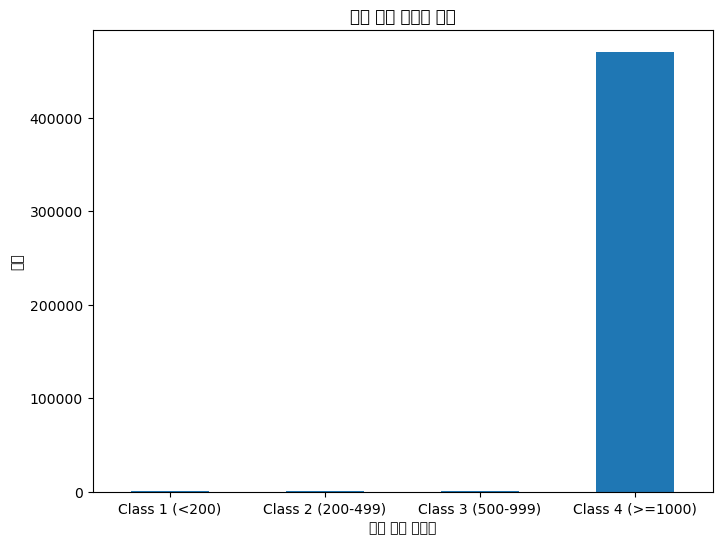

In [17]:
# 시각화
# 막대 그래프로 시각화
plt.figure(figsize=(8, 6))
ax = df2['class'].value_counts().sort_index().plot(kind='bar', rot=0)
plt.xlabel('시정 구간 클래스')
plt.ylabel('빈도')
plt.title('시정 구간 클래스 분포')
plt.xticks(range(4), ['Class 1 (<200)', 'Class 2 (200-499)', 'Class 3 (500-999)', 'Class 4 (>=1000)'])

# # 막대 위에 숫자 표시
# for index, value in enumerate(predicted_vis1['pred_class'].value_counts().values):
#     plt.text(index, value + 0.05, str(value), ha='center')

plt.show()



In [18]:
# 밤안갱
# joblib.dump(df2, 'df_rgr.pkl')

# 노트북
# joblib.dump(df2, 'C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\df_xgr.pkl')

# 데스크탑
# joblib.dump(df2, "C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\df_xgr.pkl")

# 남해안의 특성을 사용한 파생변수 생성
> **고온다습한 공기**가 유입되면서 여름철 안개(해무) 발생

In [19]:
# 열의 순서 재정렬
new_columns = ['year', 'month', 'day', 'time', 'minute', 'stn_id', 'ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10',
               'ts', 'dew_point', 'vis1', 'class']

# 데이터프레임 열 재정렬
df2 = df2.reindex(columns=new_columns)
df2

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,dew_point,vis1,class
895952,0,1,1,0,10,4,0.878333,0.161290,0.273239,0.0,0.163113,0.0,0.075724,0.153920,20000.0,4
895953,0,1,1,0,20,4,0.970000,0.236559,0.273239,0.0,0.165245,0.0,0.080178,0.154876,20000.0,4
895954,0,1,1,0,30,4,0.939722,0.215054,0.273239,0.0,0.168443,0.0,0.075724,0.156310,20000.0,4
895955,0,1,1,0,40,4,0.983056,0.182796,0.270423,0.0,0.174840,0.0,0.075724,0.156788,20000.0,4
895956,0,1,1,0,50,4,0.982500,0.247312,0.267606,0.0,0.170576,0.0,0.075724,0.152486,20000.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156455,2,12,31,23,10,4,0.848056,0.827957,0.416901,0.0,0.470149,0.0,0.089087,0.413480,20000.0,4
3156456,2,12,31,23,20,4,0.816111,0.612903,0.411268,0.0,0.469083,0.0,0.080178,0.408222,20000.0,4
3156457,2,12,31,23,30,4,0.761667,0.526882,0.408451,0.0,0.478678,0.0,0.077951,0.410134,20000.0,4
3156458,2,12,31,23,40,4,0.750833,0.494624,0.405634,0.0,0.486141,0.0,0.073497,0.411090,20000.0,4


In [20]:
df_train = df2.copy()

# fog_test 전처리

In [22]:
df_test = pd.read_csv("fog_test.csv", index_col=0)


In [23]:
df_test.columns = [col.split('.')[-1] if '.' in col else col for col in df_test.columns]
df_test

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class
1,L,1,1,0,0,AI,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6,NaN
2,L,1,1,0,10,AI,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6,NaN
3,L,1,1,0,20,AI,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7,NaN
4,L,1,1,0,30,AI,323.6,0.7,-2.6,0.0,88.7,0.0,-1.6,NaN
5,L,1,1,0,40,AI,208.4,0.2,-2.6,0.0,89.0,0.0,-1.6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262796,L,12,31,23,10,ED,338.8,6.1,4.5,0.0,71.3,0.0,1.9,NaN
262797,L,12,31,23,20,ED,335.2,5.8,4.6,0.0,71.4,0.0,1.9,NaN
262798,L,12,31,23,30,ED,337.1,5.3,4.5,0.0,72.1,0.0,1.8,NaN
262799,L,12,31,23,40,ED,322.0,3.7,4.3,0.0,72.5,0.0,1.4,NaN


In [24]:
df_test['year'] = df_test['year'].map({'L': 3})
df_test['year'].value_counts()

3    262800
Name: year, dtype: int64

In [25]:
# 첫 글자를 추출하여 새로운 열 생성
df_test['first_letter'] = df_test['stn_id'].str[0]

# 알파벳 순서에 따라 번호를 부여
alphabet_order = {char: idx for idx, char in enumerate(sorted(df_test['first_letter'].unique()))}
df_test['stn_id'] = df_test['first_letter'].map(alphabet_order)
df_test.drop(columns=['first_letter'], inplace=True)

df_test['stn_id'].value_counts()

0    52560
1    52560
2    52560
3    52560
4    52560
Name: stn_id, dtype: int64

In [26]:
# m(4, E)번 지역만 추출
df_test = df_test[df_test['stn_id'].isin([m])]
df_test['stn_id'].value_counts()

4    52560
Name: stn_id, dtype: int64

In [27]:
numeric_cols = ['ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts']

# -99.9 값을 NaN으로 변환
df_test[numeric_cols] = df_test[numeric_cols].replace(-99.9, np.nan)

# 선형보간법을 이용하여 NaN값 처리
df_test[numeric_cols] = df_test[numeric_cols].interpolate(method='linear')

c:\Users\Hong_PC\anaconda3\envs\mjh\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [28]:
# NaN 값 남았는지 확인
ws10_deg = df_test[df_test['ws10_deg'] == -99.9]
ws10_ms = df_test[df_test['ws10_ms'] == -99.9]
ta = df_test[df_test['ta'] == -99.9]
hm = df_test[df_test['hm'] == -99.9]
sun10 = df_test[df_test['sun10'] == -99.9]
ts = df_test[df_test['ts'] == -99.9]

print(ws10_deg)
print(ws10_ms)
print(ta)
print(hm)
print(sun10)
print(ts)

Empty DataFrame
Columns: [year, month, day, time, minute, stn_id, ws10_deg, ws10_ms, ta, re, hm, sun10, ts, class]
Index: []
Empty DataFrame
Columns: [year, month, day, time, minute, stn_id, ws10_deg, ws10_ms, ta, re, hm, sun10, ts, class]
Index: []
Empty DataFrame
Columns: [year, month, day, time, minute, stn_id, ws10_deg, ws10_ms, ta, re, hm, sun10, ts, class]
Index: []
Empty DataFrame
Columns: [year, month, day, time, minute, stn_id, ws10_deg, ws10_ms, ta, re, hm, sun10, ts, class]
Index: []
Empty DataFrame
Columns: [year, month, day, time, minute, stn_id, ws10_deg, ws10_ms, ta, re, hm, sun10, ts, class]
Index: []
Empty DataFrame
Columns: [year, month, day, time, minute, stn_id, ws10_deg, ws10_ms, ta, re, hm, sun10, ts, class]
Index: []


In [29]:
df_test['re'].replace(-99.9, np.nan, inplace=True)
df_test['re'] = df_test['re'].ffill()
df_test['re'] = df_test['re'].bfill()

df_test['re'].value_counts()

c:\Users\Hong_PC\anaconda3\envs\mjh\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
c:\Users\Hong_PC\anaconda3\envs\mjh\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\Hong_PC\anaconda3\envs\mjh\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

0.0    49516
1.0     3044
Name: re, dtype: int64

In [30]:
import matplotlib.pyplot as plt

# 이상치 탐지 함수
def detect_outliers_shewhart(data):
    mean = data.mean()
    std = data.std()
    ucl = mean + 3 * std
    lcl = mean - 3 * std
    outliers = data[(data > ucl) | (data < lcl)]
    return outliers, ucl, lcl

# # 각 열에 대해 이상치 탐지 및 시각화
outliers_dict = {}
for col in numeric_cols:
    outliers, ucl, lcl = detect_outliers_shewhart(df_test[col])
    outliers_dict[col] = outliers
    print(f'{col} - 이상치 개수: {len(outliers)}')

    # # 시각화
    # plt.figure(figsize=(10, 6))
    # plt.plot(df[col], label='Data')
    # plt.axhline(y=ucl, color='r', linestyle='--', label='UCL (3σ)')
    # plt.axhline(y=lcl, color='r', linestyle='--', label='LCL (3σ)')
    # plt.scatter(outliers.index, outliers, color='r', label='Outliers')
    # plt.title(f'Shewhart Control Chart for {col}')
    # plt.legend()
    # plt.show()

# 이상치 출력
for col, outliers in outliers_dict.items():
    print(f'{col} 이상치:\n{outliers}\n')

ws10_deg - 이상치 개수: 0
ws10_ms - 이상치 개수: 507
ta - 이상치 개수: 35
hm - 이상치 개수: 7
sun10 - 이상치 개수: 329
ts - 이상치 개수: 99
ws10_deg 이상치:
Series([], Name: ws10_deg, dtype: float64)

ws10_ms 이상치:
210459    11.5
210510    11.1
210511    11.7
210512    11.5
210567    11.0
          ... 
262742    11.3
262743    13.1
262744    14.3
262745    13.6
262746    11.2
Name: ws10_ms, Length: 507, dtype: float64

ta 이상치:
213715   -10.8
213716   -10.8
213717   -10.9
213718   -10.9
213719   -10.9
213720   -10.9
213721   -10.9
213722   -10.9
213723   -11.0
213724   -11.0
213725   -11.1
213726   -11.1
213727   -11.0
213728   -11.1
213729   -11.1
213730   -11.2
213731   -11.1
213732   -11.1
213733   -11.1
213734   -11.1
213735   -11.1
213736   -11.1
213737   -11.1
213738   -11.2
213739   -11.3
213740   -11.4
213741   -11.4
213742   -11.4
213743   -11.4
213744   -11.4
213745   -11.3
213746   -11.3
213747   -11.3
213748   -11.2
213749   -11.0
Name: ta, dtype: float64

hm 이상치:
224880    10.8
224883    11.0
224884    10.

In [31]:
# 이상치 값을 NaN으로 대체하고 선형 보간법으로 채움
for col, outliers in outliers_dict.items():
    df_test.loc[outliers.index, col] = np.nan
    df_test[col] = df_test[col].interpolate(method='linear', limit_direction='both')

# 보간 후 데이터 확인
for col, outliers in outliers_dict.items():
    print(f'{col} 보간 후 데이터:\n{df_test[col]}\n')

ws10_deg 보간 후 데이터:
210241    266.7
210242    280.1
210243    287.9
210244    274.8
210245    271.7
          ...  
262796    338.8
262797    335.2
262798    337.1
262799    322.0
262800     33.6
Name: ws10_deg, Length: 52560, dtype: float64

ws10_ms 보간 후 데이터:
210241    4.5
210242    4.1
210243    4.1
210244    4.4
210245    4.9
         ... 
262796    6.1
262797    5.8
262798    5.3
262799    3.7
262800    2.8
Name: ws10_ms, Length: 52560, dtype: float64

ta 보간 후 데이터:
210241    2.1
210242    2.0
210243    1.9
210244    2.0
210245    2.0
         ... 
262796    4.5
262797    4.6
262798    4.5
262799    4.3
262800    4.3
Name: ta, Length: 52560, dtype: float64

hm 보간 후 데이터:
210241    52.5
210242    53.8
210243    55.6
210244    54.8
210245    55.5
          ... 
262796    71.3
262797    71.4
262798    72.1
262799    72.5
262800    73.7
Name: hm, Length: 52560, dtype: float64

sun10 보간 후 데이터:
210241    0.0
210242    0.0
210243    0.0
210244    0.0
210245    0.0
         ... 
262796    0.0

c:\Users\Hong_PC\anaconda3\envs\mjh\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
c:\Users\Hong_PC\anaconda3\envs\mjh\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [32]:
# NaN 값 남았는지 확인
print(df_test.isnull().sum())

year            0
month           0
day             0
time            0
minute          0
stn_id          0
ws10_deg        0
ws10_ms         0
ta              0
re              0
hm              0
sun10           0
ts              0
class       52077
dtype: int64


In [33]:
# 이슬점 온도 계산 함수
def calculate_dew_point(temperature, humidity):
    # 계산식: T_d = T - ((100 - RH) / 5)
    dew_point = temperature - ((100 - humidity) / 5)
    return dew_point

# 이슬점 온도 파생변수 생성
df_test['dew_point'] = calculate_dew_point(df_test['ta'], df_test['hm'])

c:\Users\Hong_PC\anaconda3\envs\mjh\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
# 계절별 구분
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

df_test['season'] = df_test['month'].apply(get_season)

# 정규화할 열 지정
numeric_cols = ['ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts', 'dew_point']

# 계절별 정규화
scalers = {}
for season in df_test['season'].unique():
    scaler = MinMaxScaler()
    mask = df_test['season'] == season
    df_test.loc[mask, numeric_cols] = scaler.fit_transform(df_test.loc[mask, numeric_cols])
    scalers[season] = scaler

# 'season' 열 제거
df_test = df_test.drop(columns=['season'])

# 열의 순서 재정렬
new_columns = ['year', 'month', 'day', 'time', 'minute', 'stn_id', 'ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10',
               'ts', 'dew_point', 'vis1', 'class']

# 결과 출력
df_test = df_test.reindex(columns=new_columns)
df_test

c:\Users\Hong_PC\anaconda3\envs\mjh\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
c:\Users\Hong_PC\anaconda3\envs\mjh\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
c:\Users\Hong_PC\anaconda3\envs\mjh\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,dew_point,vis1,class
210241,3,1,1,0,0,4,0.741039,0.412844,0.437931,0.0,0.472579,0.0,0.086162,0.409787,NaN,NaN
210242,3,1,1,0,10,4,0.778272,0.376147,0.434483,0.0,0.487748,0.0,0.080940,0.413802,NaN,NaN
210243,3,1,1,0,20,4,0.799944,0.376147,0.431034,0.0,0.508751,0.0,0.078329,0.420326,NaN,NaN
210244,3,1,1,0,30,4,0.763545,0.403670,0.434483,0.0,0.499417,0.0,0.080940,0.418821,NaN,NaN
210245,3,1,1,0,40,4,0.754932,0.449541,0.434483,0.0,0.507585,0.0,0.080940,0.422334,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262796,3,12,31,23,10,4,0.941373,0.559633,0.520690,0.0,0.691949,0.0,0.177546,0.564366,NaN,NaN
262797,3,12,31,23,20,4,0.931370,0.532110,0.524138,0.0,0.693116,0.0,0.177546,0.567378,NaN,NaN
262798,3,12,31,23,30,4,0.936649,0.486239,0.520690,0.0,0.701284,0.0,0.174935,0.568381,NaN,NaN
262799,3,12,31,23,40,4,0.894693,0.339450,0.513793,0.0,0.705951,0.0,0.164491,0.565370,NaN,NaN


In [35]:
df_test['class'].replace(-99, float('nan'), inplace=True)

In [36]:
joblib.dump(df_train, 'df_train.pkl')
joblib.dump(df_test, 'df_test.pkl')

['df_test.pkl']

In [37]:
# df_train.to_csv('df_train.csv')
# df_test.to_csv('df_test.csv')

# df2_reduced 만들기

In [38]:
import joblib
df_train = joblib.load('df_train.pkl')

In [39]:
df_train

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,dew_point,vis1,class
895952,0,1,1,0,10,4,0.878333,0.161290,0.273239,0.0,0.163113,0.0,0.075724,0.153920,20000.0,4
895953,0,1,1,0,20,4,0.970000,0.236559,0.273239,0.0,0.165245,0.0,0.080178,0.154876,20000.0,4
895954,0,1,1,0,30,4,0.939722,0.215054,0.273239,0.0,0.168443,0.0,0.075724,0.156310,20000.0,4
895955,0,1,1,0,40,4,0.983056,0.182796,0.270423,0.0,0.174840,0.0,0.075724,0.156788,20000.0,4
895956,0,1,1,0,50,4,0.982500,0.247312,0.267606,0.0,0.170576,0.0,0.075724,0.152486,20000.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156455,2,12,31,23,10,4,0.848056,0.827957,0.416901,0.0,0.470149,0.0,0.089087,0.413480,20000.0,4
3156456,2,12,31,23,20,4,0.816111,0.612903,0.411268,0.0,0.469083,0.0,0.080178,0.408222,20000.0,4
3156457,2,12,31,23,30,4,0.761667,0.526882,0.408451,0.0,0.478678,0.0,0.077951,0.410134,20000.0,4
3156458,2,12,31,23,40,4,0.750833,0.494624,0.405634,0.0,0.486141,0.0,0.073497,0.411090,20000.0,4


In [40]:
df_train[df_train['class']==4]

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,dew_point,vis1,class
895952,0,1,1,0,10,4,0.878333,0.161290,0.273239,0.0,0.163113,0.0,0.075724,0.153920,20000.0,4
895953,0,1,1,0,20,4,0.970000,0.236559,0.273239,0.0,0.165245,0.0,0.080178,0.154876,20000.0,4
895954,0,1,1,0,30,4,0.939722,0.215054,0.273239,0.0,0.168443,0.0,0.075724,0.156310,20000.0,4
895955,0,1,1,0,40,4,0.983056,0.182796,0.270423,0.0,0.174840,0.0,0.075724,0.156788,20000.0,4
895956,0,1,1,0,50,4,0.982500,0.247312,0.267606,0.0,0.170576,0.0,0.075724,0.152486,20000.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156455,2,12,31,23,10,4,0.848056,0.827957,0.416901,0.0,0.470149,0.0,0.089087,0.413480,20000.0,4
3156456,2,12,31,23,20,4,0.816111,0.612903,0.411268,0.0,0.469083,0.0,0.080178,0.408222,20000.0,4
3156457,2,12,31,23,30,4,0.761667,0.526882,0.408451,0.0,0.478678,0.0,0.077951,0.410134,20000.0,4
3156458,2,12,31,23,40,4,0.750833,0.494624,0.405634,0.0,0.486141,0.0,0.073497,0.411090,20000.0,4


In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# 특성과 타겟 분리
X = df_train.drop(columns=['class'])
y = df_train['class']

# 클래스 분포 확인
print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({4: 470655, 3: 1092, 1: 864, 2: 857})


In [ ]:
'''
# 언더샘플링
under = RandomUnderSampler(sampling_strategy='auto')
X_res, y_res = under.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

# 오버샘플링
smote = SMOTE(sampling_strategy='auto')
X_res, y_res = smote.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

# 재샘플링된 데이터프레임 생성
df_resampled = pd.concat([X_res, y_res], axis=1)
'''

"\n# 언더샘플링\nunder = RandomUnderSampler(sampling_strategy='auto')\nX_res, y_res = under.fit_resample(X, y)\nprint('Resampled dataset shape %s' % Counter(y_res))\n\n# 오버샘플링\nsmote = SMOTE(sampling_strategy='auto')\nX_res, y_res = smote.fit_resample(X, y)\nprint('Resampled dataset shape %s' % Counter(y_res))\n\n# 재샘플링된 데이터프레임 생성\ndf_resampled = pd.concat([X_res, y_res], axis=1)\n"

In [ ]:
# 클래스 4에 해당하는 데이터만 분리
df_class_4 = df_train[df_train['class'] == 4].copy()

# 일정 간격으로 데이터 제거
df_class_4_indices_to_drop = df_class_4.index[2::3]  # 3행에 하나씩 제거할 인덱스 추출
df_class_4_dropped = df_class_4.drop(df_class_4_indices_to_drop)

# df_train에서 클래스 4에 해당하는 인덱스만 추출
indices_class_4_in_train = df_train[df_train['class'] == 4].index

# df_train에서 클래스 4에 해당하는 인덱스를 제거하고, 언더샘플링된 데이터로 교체
df_train.drop(indices_class_4_in_train, inplace=True)
df_train = pd.concat([df_train, df_class_4_dropped], ignore_index=True)

# 인덱스 재정렬
df_train.reset_index(drop=True, inplace=True)

# 결과 확인
print(df_train)

        year  month  day  time  minute  stn_id  ws10_deg   ws10_ms        ta  \
0          0      1    7     4      40       4  0.129722  0.193548  0.639437   
1          0      1    7     6       0       4  0.799167  0.053763  0.642254   
2          0      1    7     6      30       4  0.661389  0.150538  0.656338   
3          0      2   12    13      20       4  0.255556  0.204301  0.684507   
4          0      2   12    13      30       4  0.196111  0.247312  0.687324   
...      ...    ...  ...   ...     ...     ...       ...       ...       ...   
316578     2     12   31    22      40       4  0.871667  0.591398  0.411268   
316579     2     12   31    23       0       4  0.844722  0.709677  0.414085   
316580     2     12   31    23      10       4  0.848056  0.827957  0.416901   
316581     2     12   31    23      30       4  0.761667  0.526882  0.408451   
316582     2     12   31    23      40       4  0.750833  0.494624  0.405634   

         re        hm     sun10        

In [ ]:
# 언더 샘플링한 데이터
joblib.dump(df_train, 'df_train_undersampling.pkl')


['df_train_undersampling.pkl']